## Hierarchical Clustering for Topic Generation

Hierarchical clustering is a type of unsupervised learning algorithm that forms clusters with a bottom up approach. This means that each data point starts as its own cluster and is grouped with others to form bigger clusters. An advantage of this over K-Means Clustering is that you do not need to specify a predefined number of clusters. However, because of this, hierarchical clustering is more computationally expensive. A reasonably sized sample taken from the full dataset should get around this issue.

In [8]:
import numpy as np
import pandas as pd
import nltk
import re
from re import sub
import os
import codecs
import random
import spacy

from nltk.stem.snowball import SnowballStemmer
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from matplotlib.pyplot import figure
from collections import defaultdict

from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter

from common_modules import text_to_word_list

### 1. Data Preprocessing

To start, the data needs to be preprocessed. For this experiment, we are working with the vaccine data.

In [9]:
full_df = pd.read_csv('../../data/travel_full.csv')
full_df.head(3)

,Unique ID,Date,URL,Page title,Comment,Tags,Refining details,Status,What's wrong,Lang,Tags confirmed
0,60a063c82b6da5147c289783,"16 May, 2021",travel.gc.ca/travel-covid/travel-restrictions/...,Flying to Canada: COVID-19 testing for travell...,Quero viajar de Portugal para a Inglaterra,Restrictions or Requirements,Travel outside Canada,New,Other reason,EN,checked
1,60a067a62b6da5147c28978d,"16 May, 2021",travel.gc.ca/travel-covid,"""COVID-19: Travel, testing, quarantine and bor...",If one is cleared of all tests and given the o...,Quarantine,Have been vaccinated,New,NaN,EN,checked
2,60a06bde2b6da5147c289790,"16 May, 2021",travel.gc.ca/travel-covid/travel-restrictions/...,Mandatory quarantine or isolation – Travel res...,Why if fully vaccinated would you need to quar...,Quarantine,Have been vaccinated,New,The information is hard to understand,EN,checked


Before clustering, we have to separate the English comments from the French comments. Then clean the comments by removing repeated punctuations, letters, etc.

In [10]:
## Filter languages
en_df = full_df[full_df["Lang"]=='EN']
#fr_df = full_df[full_df["Lang"]=="FR"]

## Only keep Comments and Tags
en_df = en_df[["Comment", "Tags"]]
#fr_df = fr_df[["Comment", "Tags"]]

In [11]:
cleaned_df = en_df.copy()
cleaned_df.Comment = cleaned_df.Comment.apply(lambda x: text_to_word_list(x))
cleaned_df.Comment = cleaned_df.Comment.str.join(' ')
cleaned_df.head()

,Comment,Tags
0,quero viajar de portugal para a inglaterra,Restrictions or Requirements
1,if one is cleared of all tests and given the o...,Quarantine
2,why if fully vaccinated would you need to quar...,Quarantine
3,can i land in the us and cross border by car,Restrictions or Requirements
4,i m trying to figure out if i can quarantine o...,Quarantine


After filtering by language, we can take a reasonably-sized sample. For this experiment, 10% of the full data should suffice. Random seed is 123.

In [12]:
sample_df = cleaned_df.sample(int(0.1*len(cleaned_df)), random_state=123)

In [13]:
sample_df.head()

,Comment,Tags
2257,what if travelers are fully vaccinated ?,Restrictions or Requirements
7293,in order to be able to sell our property it is...,Can I enter Canada
1712,enforcement,Restrictions or Requirements
7692,i am a truck driver will be taking a load from...,Restrictions or Requirements
12391,what about new permanent resident,Restrictions or Requirements


In [14]:
cleaned_df['Tags'].value_counts()

Restrictions or Requirements                                  2659
Hotels                                                        2517
Can I enter Canada                                            2097
Quarantine                                                    1567
Testing                                                       1250
Provincial restrictions                                        928
Design / content                                               729
Other (Contact / Travel outside / ArriveCan / Mad people )     711
Hotels,Design / content                                          1
Hotels,Testing                                                   1
Restrictions or Requirements,Can I enter Canada                  1
Name: Tags, dtype: int64

In [15]:
sample_df['Tags'].value_counts()

Hotels                                                        269
Restrictions or Requirements                                  240
Can I enter Canada                                            222
Quarantine                                                    179
Testing                                                       115
Provincial restrictions                                        87
Design / content                                               68
Other (Contact / Travel outside / ArriveCan / Mad people )     66
Name: Tags, dtype: int64

## 2. Hierarchical Clustering
Inspired by Brandon Rose's work on [movie clustering](http://brandonrose.org/clustering)

### 2.a. Tokenizing and Stemming
Before clustering, we have to tokenize and stem the comments. Tokenizing is just a way of splitting sentences into individual words, and stemming is the process of breaking words down to their core. This is needed to group the same words with different spellings together. For example, "vaccine", "vaccines" and "vaccination" all have "vaccin" as their stem.

In [16]:
stemmer = SnowballStemmer("english")

def tokenize_plus_stem(text, stem=True):
    '''tokenize the comments then stem them if stem is true. Otherwise, just return the tokenized comments. 
    Based on the function of Brandon Rose in http://brandonrose.org/clustering'''
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    if stem:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

Now that we have a tokenizer and stemmer function. We can create a lookup table that can cross-reference tokenized and stemmed words.

In [17]:
comments = sample_df.Comment.to_list()
tags = sample_df.Tags.to_list()
idx = sample_df.index.to_list()
vocab_stemmed = []
vocab_tokenized = []
for i in comments:
    words_stemmed = tokenize_plus_stem(i)
    vocab_stemmed.extend(words_stemmed)
    
    words_tokenized = tokenize_plus_stem(i, stem=False)
    vocab_tokenized.extend(words_tokenized)

In [18]:
idx2comment = {}
idx2tag = {}
for i, comment in enumerate(comments):
    index = idx[i]
    tag = tags[i]
    idx2comment[index] = comment
    idx2tag[index] = tag

In [19]:
vocab_frame = pd.DataFrame({'words': vocab_tokenized}, index = vocab_stemmed)

### 2.b. TF-IDF Vectorization

Term frequency-Inverse document frequency (Tf-Idf) is a way to measure word relevance in a text. Each word is assigned a weight based on its frequency in individual comments and the whole corpus.

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize_plus_stem, ngram_range=(2,3))

In [21]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df.Comment)

print(tfidf_matrix.shape)

C:\Users\Jan\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(1246, 15681)
Wall time: 569 ms


Let's look at some features for our model.

In [22]:
features = tfidf_vectorizer.get_feature_names()
features[1000:1010]

['aug27 returnign sept',
 'august make',
 'august make use',
 'august trip',
 'august trip bc',
 'aunt cousion',
 'aunt cousion brother',
 'aunt die',
 'aunt die year',
 'author broken']

After vectorizing, we compute for the cosine similarity of each of the features which we will then feed to the hierarchical clustering model.

In [23]:
distance = 1 - cosine_similarity(tfidf_matrix)

### 2.c. Clustering

In [24]:
%%time
agglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')
agglo.fit(distance)

Wall time: 1.12 s


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [25]:
counts = np.zeros(agglo.children_.shape[0])
n_samples = len(agglo.labels_)
for i, merge in enumerate(agglo.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
        
linkage_matrix = np.column_stack([agglo.children_, agglo.distances_, counts]).astype(float)

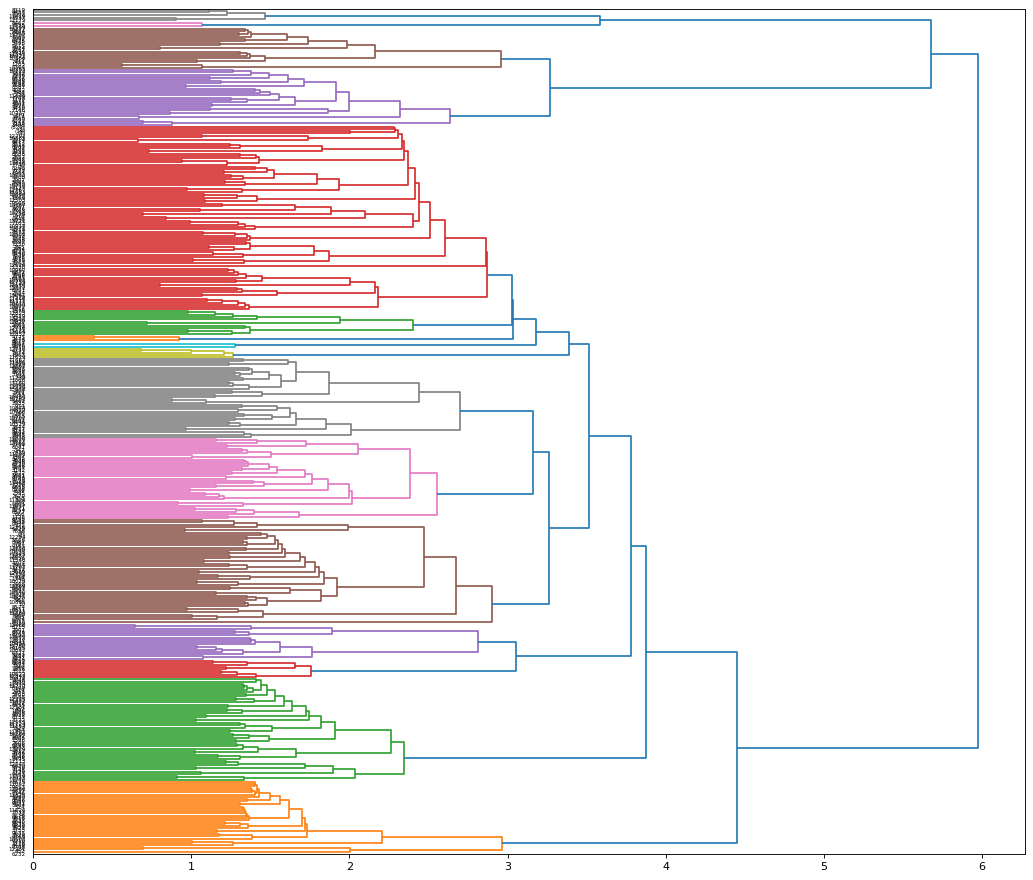

In [26]:
figure(figsize=(16, 14), dpi=80)
den = dendrogram(linkage_matrix, truncate_mode='level',p=20, color_threshold = 0.5*max(linkage_matrix[:,2]), orientation='right', labels=idx)

## 3. Reading the Dendrogram
Based on [this](https://nbviewer.jupyter.org/gist/vals/150ec97a5b7db9c82ee9) tutorial.

Because a dendrogram with thousands of rows of text is virtually unreadable. We can neatly group the comments together in a list form.

In [27]:
cluster_idxs = defaultdict(list)
for c, pi in zip(den['color_list'], den['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

In [28]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html

In [29]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [30]:
get_cluster_classes(den)

C1,"[6232, 452, 12231, 6768, 1778, 9210, 4449, 9769, 3529, 10503, 9635, 3755, 8535, 6040, 9849, 3523, 11626, 524, 2833, 12, 8619, 9816, 2237, 5904, 9031, 9080, 4482, 3627, 12986, 5146, 11325, 11042, 3675, 9453, 9990, 2474, 4775, 8629]"
C2,"[3023, 11519, 11770, 9463, 7739, 7145, 5759, 12545, 11113, 6630, 6949, 8722, 3495, 4186, 4812, 4887, 6796, 13229, 2606, 1396, 1692, 10160, 8005, 11892, 954, 11154, 11124, 5524, 12573, 3722, 6732, 9022, 1896, 457, 1908, 12131, 5855, 11432, 12225, 2822, 6588, 5468, 12270, 11474, 8199, 319, 2653, 3680, 2648, 13049, 1271, 12852, 12718, 4092, 5505, 12827, 12823, 1376, 9439, 13253, 9846]"
C3,"[10622, 3322, 12842, 10472, 3858, 540, 6684, 6859, 3323, 11111, 11446, 10215, 9300, 10977, 5816, 7579, 13061, 8991, 12372, 2884, 6935, 12144, 12759, 10592, 6871, 10960, 9806, 2296, 6181, 1336, 12524, 4579, 4515, 3202, 7339, 8240, 7695, 2984, 845, 8225, 1250, 6392, 12533, 8372, 9053, 1335, 3058, 7103, 13221, 10918, 10671, 4219, 6648, 270, 1879, 10758, 7703, 8026, 7207, 10387, 7703, 9568, 12503, 6025, 10884, 1309, 12767, 3127, 11053, 6380, 5065, 10710, 4408, 10033, 2907, 1907, 2722, 9459, '(2)', 11848, 5332, 2740, 2852, 8688, 5082, 2431, 3508, 4043, 8512, 9197, 9417, 2014, 10865, 12792, '(4)', '(14)', '(2)', '(822)']"
C4,"[8414, 7847, 9165, 12780, 10642, 6321, 5282, 12512, 3852, 4841, 10496, 8263, 8326, 13140, 8115, 12488, 2901, 7153, 6222, 3498, 7700, 3914, 279, 10237, 7146, 3410, 3928, 3907, 1172, 7768, 2931, 3883, 4082, 738, 11649, 8587, 7586, 6764, 8286, 6536, 6472, 1333, 10223, 7936]"
C5,"[6020, 6015, 805, 9869, 6304, 10911, 6451, 11580, 10, 10885, 8574, 4970, 10241, 981, 5208, 10540, 5997, 8483, 2468, 10024, 12869, 918, 13129, 1748, 12997, 4626, 11793, 3904, 4411, 4304, 11546, 6556, 12857, 2343, 10535, 4760, 12258, 797, 8067, 9167, 5568, 12294, '(2)', '(3)', 7656, 5429, 8844, 8046, 221, 12316, 5364, 1205, 10285, 7411, 812, 11345, 9938, 10921, 10556, 2257, 5924, 5615, 5496, 6425, 8092, 11707, 6468, 9884, 10277, 7060]"
C6,"[6795, 1126, 8254, 4571, 6577, 666, 5601, 558, 11937, 2679, 7595, 958, 11324, 539, 8238, 6855, 7226, 11468, 3629, 8769, 8784, 5681, 7872, 3142, 5467, 1898, 4836, 6720, 5646, 4205, 7467, 7430, 542, 11093, 6041, 7794, 9627, 11020, 12166, 3855, 8462, 11169]"
C7,"[7945, 8894, 8958, 5133, 8417, 10529, 9446, 3844, 6461, 10702, 6513, 281, 10766, 4859, 10544, 974, 5462, 10162, 2933, 10480, 2055, 7711, 808, 1099, 13180, 12220, 13078, 1066, 11739, 3101, 8938, 130, 1289, 8607, 12862, 1499, 11486, 11667, 12179, 3537, 11419, 5002, 4453, 8319]"
C8,"[4373, 12710, 1074, 1903, 11629]"
C9,"[6098, 8617, 4910]"
C0,[11419]


## Tag Generation Experiment

In [31]:
from collections import defaultdict, Counter
import spacy
nlp_en = spacy.load("en_core_web_sm")
#nlp_fr = spacy.load("fr_core_news_sm")
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords

Now that we have our list of clusters we can find out if each cluster is homogenous or heterogeneous.

In [32]:
def detect_new_tag_clustering(cluster,threshold=0.6):
    """
    This function determine whether the input cluster needs a new tag or not. 
    If percentage of the dominant tag is over shreshold hundredths, this cluster does not need a new tag.
    If percentage of the dominant tag is below shreshold hundredths, this cluster needs a new tag.
    
    Parameters:
    -----------
        cluster: a list of tags in the cluster
    
    Return:
    -----------
        boolean: yes-this cluster needs a new tag;no-this cluster does not need a new tag
    """
    counter_dict = defaultdict(int)
    for tag in cluster:
        counter_dict[tag]+=1
    total = sum(list(counter_dict.values()))
    tag_count_pairs = sorted(list(counter_dict.items()),key = lambda x: x[1],reverse=True)
    if tag_count_pairs[0][1]/total>threshold:
        return True
    else:
        return False

Then, once we find a heterogeneous cluster, we want to generate some keywords for possible tags.

In [33]:
def generate_tag_candidates(comments, approach="NER", langauge="English", top=10):
    """
    This function takes a list of comments/indices and generate a list of potential tags.
    
    Parameters:
    -----------
        comments: list of str
        approach: define the approach to generate new tags. The default one is "NER". You can also use "unigram", "bigram". 
        langauge: English or French
        top: return top 10(defalut) common entities
    Return:
    -----------
        candidates: list of str
    """

    if langauge=="English":
        nlp = nlp_en
    elif langauge=="French":
        nlp = nlp_fr
    
    entity_counter_dict = defaultdict(int)
    n_gram_counter_dict = defaultdict(int)
    
    if approach=="NER":
        for comment in comments:
            doc = nlp(comment)
            for ent in doc.ents:
                entity_counter_dict[ent.text] += 1
            entity_count_pairs = sorted(list(entity_counter_dict.items()),key = lambda x: x[1],reverse=True)
            return [ent for (ent, count) in entity_count_pairs[:top]]
        
    elif approach=="bigram" or approach=="trigram":
        for comment in comments:
            doc = nlp(comment)
            tokens = [token.lemma_ for token in doc]
            no_stopwords = [token for token in tokens if token not in stopwords.words('english')]
            n=2 if approach=="bigram" else 3
            n_grams = ngrams(no_stopwords, n)
            for n_gram in n_grams:
                n_gram_counter_dict[n_gram] += 1
        n_gram_count_pairs = sorted(list(n_gram_counter_dict.items()), key = lambda x: x[1],reverse=True)
        return [n_gram for (n_gram, count) in n_gram_count_pairs[:top]]
    
    elif approach=="unigram":
        for comment in comments:
            doc = nlp(comment)
            tokens = [token.lemma_ for token in doc]
            no_stopwords = [token for token in tokens if token not in stopwords.words('english')]
            n=1
            n_grams = ngrams(no_stopwords, n)
            for n_gram in n_grams:
                n_gram_counter_dict[n_gram] += 1
        n_gram_count_pairs = sorted(list(n_gram_counter_dict.items()), key = lambda x: x[1],reverse=True)
        return [n_gram for (n_gram, count) in n_gram_count_pairs[:top]]

Looking at cluster #8, we see that it's heterogeneous and the keywords generate involve the words "travel", "within", "canada", "want", telling us that users are interested in knowing about domestic travel restrictions.

In [45]:
sample_cluster = [idx2tag[idx] for idx in get_cluster_classes(den)['C1'] if isinstance(idx,int)]
tag_percentage = Counter(sample_cluster)
for tag, count in tag_percentage.copy().items():
    tag_percentage[tag] = round(count/len(sample_cluster), 2)

In [46]:
tag_percentage

Counter({'Provincial restrictions': 0.29,
         'Can I enter Canada': 0.37,
         'Quarantine': 0.03,
         'Restrictions or Requirements': 0.24,
         'Hotels': 0.05,
         'Testing': 0.03})

In [41]:
detect_new_tag_clustering(sample_cluster)

False

In [43]:
sample_cluster_comments = [idx2comment[idx] for idx in get_cluster_classes(den)['C1'] if isinstance(idx,int)]
generate_tag_candidates(sample_cluster_comments, approach='bigram', langauge="English", top=10)

[('travel', 'canada'),
 ('I', 'travel'),
 ('travel', 'within'),
 ('within', 'canada'),
 ('self', 'isolate'),
 ('canada', 'I'),
 ('want', 'travel'),
 ('canadian', 'citizen'),
 ('visit', 'parent'),
 ('isolate', 'I')]

In [44]:
sample_cluster_comments[:10]

['travelling within canada',
 'travel within canada',
 'can a tourist travel though canada to alaska and back this summer ?',
 'can i travel through canada to move to alaska ?',
 'do i have to self isolate if i travel only in bc',
 'do i need to self isolate when travelling within canada',
 'do i need to self isolate when i return to ontario from bc ?',
 'i m in new zealand i have visitor visa for canada can i travel to canada to meet my uncle aunt and cousion brother s',
 'my sister is in canada so can i travel to canada',
 'i am a us citizen who owns property in canada can i travel to inspect it']